In [1]:
import os, math, sys, random
import numpy as np
import numpy.linalg as la
import scipy.stats as st
import scipy.optimize as sopt
import matplotlib as mpl
import matplotlib.pyplot as plt
import My_TMCMC

np.random.seed(106)  # fixing the random seed

In [3]:
# baseline additive 0.0001 sigma, 0.001 dt
# sparse half as many samples
# up to 0.25 s and extrapolate

125


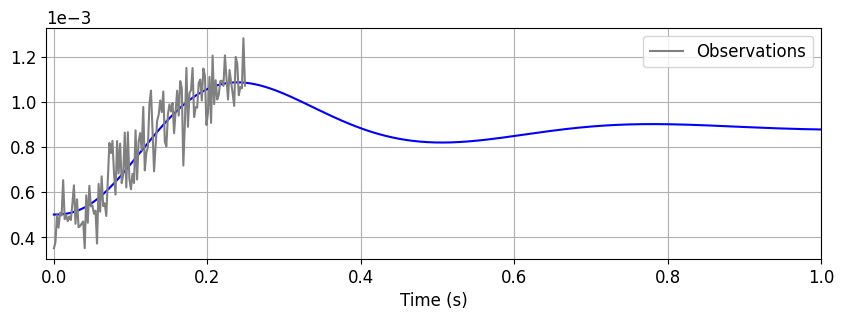

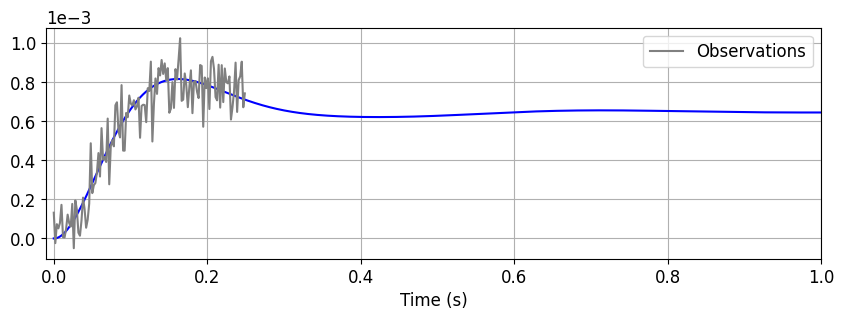

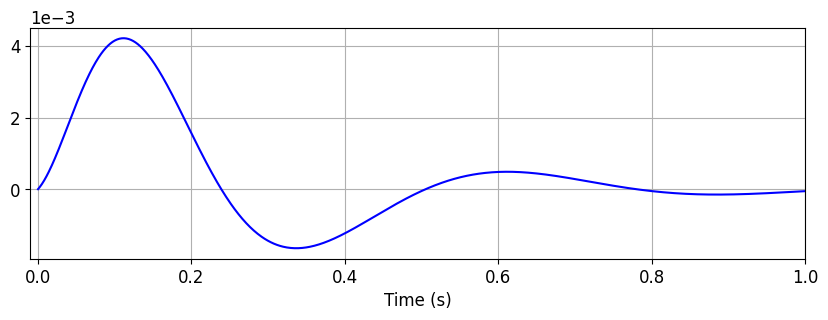

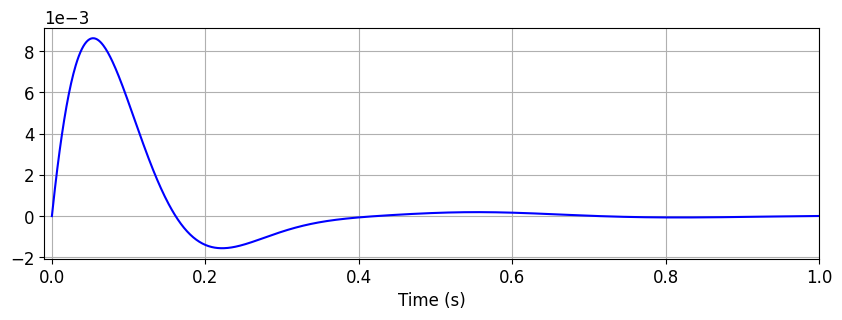

In [2]:
# The baseline timestep is 0.001 seconds, going up to 0.002 and 0.004 for more sparse tests
# Timeframe is 1s
# Typically I would cut off training to 0.25s and extrapolate up to 1


dof = 2 # degree of freedom
Y0   = [0.0005,0,0,0] # initial conditions, [disp(3), vel(3)]
mVec = [20,10] # mass vector
kVec = [2000,1000,5000] # stiffness vector
cVec = [100,110,120] # damping vector
fVec = [2,3] # damping vector
noiseSigma = 1e-4 # measurement noise strength
obsInd = [0,1]

T = 0.25
dt = 0.001
tgrd = int(T/dt) # time integration grid
tlist = np.linspace(0,T,tgrd)
sampFac = 2  # sample every sampFac time step 


Ms11 = mVec[0]
Ms12 = 0
Ms21 = 0
Ms22 = mVec[1]

Ds11 = cVec[0]+cVec[1]
Ds12 = -cVec[1]
Ds21 = -cVec[1]
Ds22 = cVec[1]+cVec[2]

Ks11 = kVec[0]+kVec[1]
Ks12 = -kVec[1]
Ks21 = -kVec[1]
Ks22 = kVec[1]+kVec[2]

Ms = np.array([[Ms11,Ms12],[Ms21,Ms22]])
invMs = np.array([[Ms22,-Ms21],[-Ms12,Ms11]])/(Ms11*Ms22-Ms21*Ms12)

Ds = np.array([[Ds11,Ds12],[Ds21,Ds22]])
Ks = np.array([[Ks11,Ks12],[Ks21,Ks22]])
f  = np.array([[2],[3]])
minvf = np.ndarray.flatten(invMs@f)

X = np.zeros((4,tgrd))
X[:,0] = Y0

for ii in range(1,tgrd):
  X[0,ii] = X[0,ii-1] + dt*(X[2,ii-1])
  X[1,ii] = X[1,ii-1] + dt*(X[3,ii-1])
  X[2:4,ii] = X[2:4,ii-1] - dt*(invMs@Ks@X[0:2,ii-1] + invMs@Ds@X[2:4,ii-1] - minvf)

### Synthetic Data ###
np.random.seed(116)
tobs = tlist[0::sampFac]
Yobs = np.zeros((len(obsInd),len(tobs)))
Nobs = len(tobs)

for i in range(len(obsInd)):
    Yobs[i,:] = X[obsInd[i],::sampFac] + noiseSigma*np.random.normal(0,1,Nobs)



T_true = 1
tgrd_true = int(T_true/dt) # time integration grid
tlist_true = np.linspace(0,T_true,tgrd_true)

Y = np.zeros((4,tgrd_true))
Y[:,0] = Y0

for ii in range(1,tgrd_true):
  Y[0,ii] = Y[0,ii-1] + dt*(Y[2,ii-1])
  Y[1,ii] = Y[1,ii-1] + dt*(Y[3,ii-1])
  Y[2:4,ii] = Y[2:4,ii-1] - dt*(invMs@Ks@Y[0:2,ii-1] + invMs@Ds@Y[2:4,ii-1] - minvf)

# Ynoisy = Ytrue[obsInd,0:] + noiseSigma*np.random.normal(0,1,tgrd)
# Yobs = Ynoisy[0::sampFac]
# tobs = tlist[0::sampFac]

# np.savetxt('Ydata.dat',Yobs)
# np.savetxt('Xdata.dat',tobs)
# np.savetxt('init.dat',Y0)

### Plotting ###

mpl.rcParams.update({'font.size':12})
for j in range(0,2*dof):
    f, ax = plt.subplots(1, figsize=(10,3))
    plt.plot(tlist_true,Y[j,:],'b-')
    if j in [0,1]:
        plt.plot(tobs,Yobs[j,:],'grey',label='Observations')
        # plt.plot(tobs,Yobs[j,:],'r.',label='Observations')
        #plt.plot(tobs,Yobs,'r-')
        #plt.plot(tobs,Yobs,'r-')
        plt.legend(loc='upper right', numpoints = 1)
    plt.grid(True)
    plt.xlabel('Time (s)')
    # plt.ylabel(r'Displacement: $u_'+str(j+1)+'$')
    plt.xlim([-0.01,T_true])
    plt.ticklabel_format(style='sci', axis='y', scilimits=(-3,3))
    # plt.ylim([-1.1,1.1])
# plt.savefig('figs/Yobs.eps',bbox_inches='tight')
print(Nobs)

In [3]:
dof = 2 # degree of freedom
Npar = 3 # number of unknown parameters
obsInd = [0,1] # what state was observed
# phiTrue = [0,1e5]
phiTrue = [100,110,120] 
phiNN = [140.705,110.2344,75.1] 
X_low = [0,0,0]
X_up = [1000,1000,1000]
mylabel = [r'$c_1$', r'$c_2$',r'$c_3$']

# Y0 = np.loadtxt('init.dat')
# Yobs = np.loadtxt('Ydata.dat')
# tobs = np.loadtxt('Xdata.dat')
noiseSig = 1e-4 # measurement noise strength


def two_dof_model(parVecIn):
    Y0   = [0.0005,0,0,0] # initial conditions, [disp(3), vel(3)]
    mVec = [20,10] # mass vector
    kVec = [2000,1000,5000] # stiffness vector
    cVec = [parVecIn[0],parVecIn[1],parVecIn[2]] # damping vector
    fVec = [2,3] # damping vector
    
    T = 0.25
    dt = 0.001
    tgrd = int(T/dt) # time integration grid
    tlist = np.linspace(0,T,tgrd)
    
    Ms11 = mVec[0]
    Ms12 = 0
    Ms21 = 0
    Ms22 = mVec[1]

    Ds11 = cVec[0]+cVec[1]
    Ds12 = -cVec[1]
    Ds21 = -cVec[1]
    Ds22 = cVec[1]+cVec[2]

    Ks11 = kVec[0]+kVec[1]
    Ks12 = -kVec[1]
    Ks21 = -kVec[1]
    Ks22 = kVec[1]+kVec[2]

    Ms = np.array([[Ms11,Ms12],[Ms21,Ms22]])
    invMs = np.array([[Ms22,-Ms21],[-Ms12,Ms11]])/(Ms11*Ms22-Ms21*Ms12)

    Ds = np.array([[Ds11,Ds12],[Ds21,Ds22]])
    Ks = np.array([[Ks11,Ks12],[Ks21,Ks22]])
    f  = np.array([[2],[3]])
    minvf = np.ndarray.flatten(invMs@f)

    X = np.zeros((4,tgrd))
    X[:,0] = Y0

    for ii in range(1,tgrd):
        X[0,ii] = X[0,ii-1] + dt*(X[2,ii-1])
        X[1,ii] = X[1,ii-1] + dt*(X[3,ii-1])
        X[2:4,ii] = X[2:4,ii-1] - dt*(invMs@Ks@X[0:2,ii-1] + invMs@Ds@X[2:4,ii-1] - minvf)

    return X[0,::sampFac], X[1,::sampFac]


def two_dof_forecast(parVecIn):
    Y0   = [0.0005,0,0,0] # initial conditions, [disp(3), vel(3)]
    mVec = [20,10] # mass vector
    kVec = [2000,1000,5000] # stiffness vector
    cVec = [parVecIn[0],parVecIn[1],parVecIn[2]] # damping vector
    fVec = [2,3] # damping vector
    
    T = 1
    dt = 0.001
    tgrd = int(T/dt) # time integration grid
    tlist = np.linspace(0,T,tgrd)
    
    Ms11 = mVec[0]
    Ms12 = 0
    Ms21 = 0
    Ms22 = mVec[1]

    Ds11 = cVec[0]+cVec[1]
    Ds12 = -cVec[1]
    Ds21 = -cVec[1]
    Ds22 = cVec[1]+cVec[2]

    Ks11 = kVec[0]+kVec[1]
    Ks12 = -kVec[1]
    Ks21 = -kVec[1]
    Ks22 = kVec[1]+kVec[2]

    Ms = np.array([[Ms11,Ms12],[Ms21,Ms22]])
    invMs = np.array([[Ms22,-Ms21],[-Ms12,Ms11]])/(Ms11*Ms22-Ms21*Ms12)

    Ds = np.array([[Ds11,Ds12],[Ds21,Ds22]])
    Ks = np.array([[Ks11,Ks12],[Ks21,Ks22]])
    f  = np.array([[2],[3]])
    minvf = np.ndarray.flatten(invMs@f)

    X = np.zeros((4,tgrd))
    X[:,0] = Y0

    for ii in range(1,tgrd):
        X[0,ii] = X[0,ii-1] + dt*(X[2,ii-1])
        X[1,ii] = X[1,ii-1] + dt*(X[3,ii-1])
        X[2:4,ii] = X[2:4,ii-1] - dt*(invMs@Ks@X[0:2,ii-1] + invMs@Ds@X[2:4,ii-1] - minvf)

    return X

def loglikfun(parVecIn):
    loglikfun_u1, loglikfun_u2  = 0.0, 0.0
    # Yout = two_dof_model(parVecIn)
    # for i in range(0,Nobs):
    #     loglikfun_u1 = loglikfun_u1 + (Yobs[0,i] - Yout[0,sampFac*i])**2
    #     loglikfun_u2 = loglikfun_u2 + (Yobs[1,i] - Yout[1,sampFac*i])**2
    Y1out,Y2out = two_dof_model(parVecIn)
    for i in range(0,Nobs):
        loglikfun_u1 = loglikfun_u1 + (Yobs[0,i] - Y1out[i])**2
        loglikfun_u2 = loglikfun_u2 + (Yobs[1,i] - Y2out[i])**2   

    return - (loglikfun_u1/(2.0*noiseSig**2) + Nobs*np.log(noiseSig) + Nobs*0.5*np.log(2*np.pi)) - (loglikfun_u2/(2.0*noiseSig**2) + Nobs*np.log(noiseSig) + Nobs*0.5*np.log(2*np.pi))  

def logpriorpdf(parVecIn):
        logprior = 0.0
        #logprior = logprior + rv2.logpdf(parVecIn[3])
        return logprior

def logpostprob(phiIn):
    #return logpriorpdf(phiIn) + loglikfun(phiIn)
    return loglikfun(phiIn)

def negativeloglik(phiIn):
    return -logpostprob(phiIn)


In [4]:
run_mcmc = 0

if run_mcmc == 1:    
    import time
    start = time.time()

    Nsmp = 10000
    MHfac = 0.2
    Xsmp,Chain,LLsmp, Evid, tmcmcFac  = My_TMCMC.TMCMC(logpostprob,Npar,X_low,X_up,Nsmp)

    end = time.time()
    print(end - start)
else:
    Nsmp = 10000
    Xsmp = np.loadtxt('msd_1_samples.dat')
    Chain = np.loadtxt('msd_1_chain.dat')

(3, 80000)
(3, 10000)


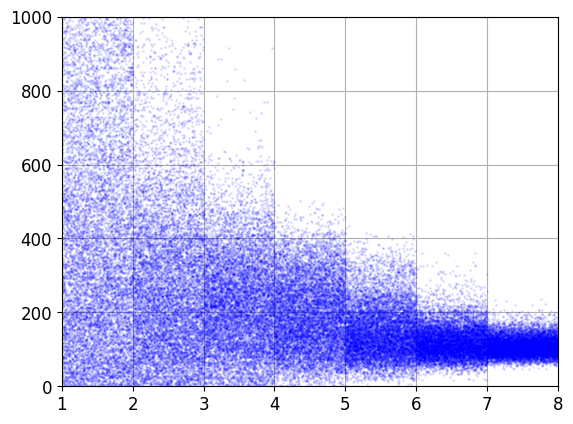

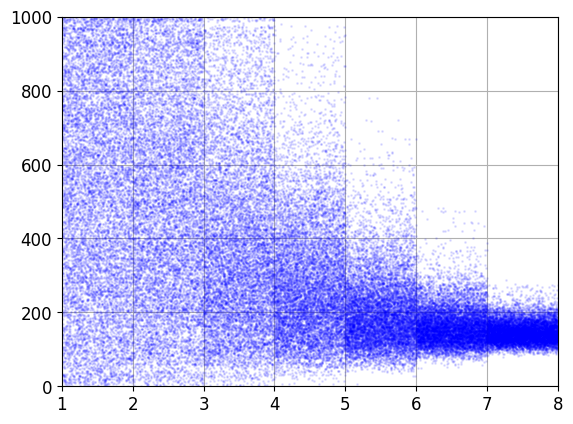

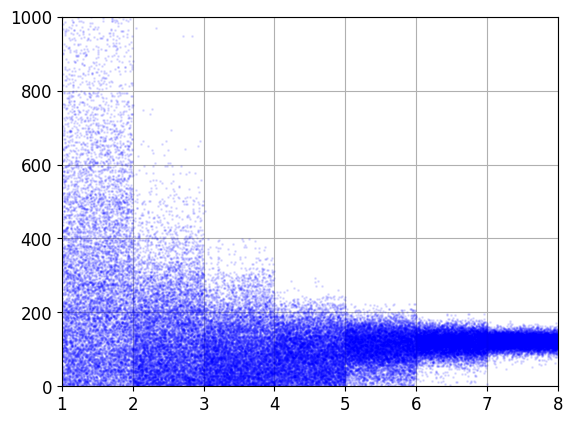

In [5]:
print(np.shape(Chain))
print(np.shape(Xsmp))

for ii in range(Npar):
  plt.figure(ii)
  plt.plot((1/Nsmp)*np.arange(0,len(Chain[ii,:])),Chain[ii,:],'b.',markersize=2,alpha=0.1)
  plt.ylim([X_low[ii],X_up[ii]])
  plt.xlim([1,8])
  # plt.xlabel(mylabel[ii])
  plt.grid(True)


In [8]:
# # phiTrue = [100,110,120] 
# Ngrd = 20
# LogLikelihood = np.zeros((Ngrd,Ngrd))
# DynLikelihood = np.zeros((Ngrd,Ngrd))
# Par1bnd = [75,150]
# Par2bnd = [75,150]
# Par1rng = np.linspace(Par1bnd[0],Par1bnd[1],Ngrd)
# Par2rng  = np.linspace(Par2bnd[0],Par2bnd[1],Ngrd)
# Par1grd,Par2grd = np.meshgrid(Par1rng,Par2rng)
# for i in range(0,Ngrd):
#     for j in range(0, Ngrd):
#         ParCur = np.array([Par1grd[i,j],Par2grd[i,j],120.0])
#         LogLikelihood[i,j] = loglikfun(ParCur)

In [9]:
# mpl.rcParams.update({'font.size':16})
# #mpl.rcParams['contour.negative_linestyle'] = 'solid'
# f, ax = plt.subplots(1, figsize=(6,5))
# plt.pcolor(Par1grd,Par2grd,np.exp(LogLikelihood),cmap='Blues')
# plt.colorbar()
# plt.grid('on',linestyle='--')
# plt.xlabel(mylabel[0])
# plt.xlabel(mylabel[1])
# plt.xticks(np.linspace(Par1bnd[0],Par1bnd[1],5))
# plt.yticks(np.linspace(Par2bnd[0],Par2bnd[1],5))
# # plt.xlim([0,6])
# # plt.ylim([0,3])
# #plt.title('Objective function')
# #plt.savefig('plot_objfun.eps',bbox_inches='tight')

In [10]:
np.savetxt('msd_1_samples.dat',Xsmp)
np.savetxt('msd_1_chain.dat',Chain)

statSmp = Xsmp.copy()
kdeMCMC= st.gaussian_kde(statSmp,bw_method = 0.1)
SigMat = kdeMCMC.covariance
# np.savetxt('SigMat.dat',SigMat)

import scipy.stats as st
from scipy.optimize import minimize
kde = st.gaussian_kde(statSmp )
def kde_fun(x):
  return -kde(x)
res = minimize(kde_fun,phiTrue, method='nelder-mead',options={'xatol': 1e-8, 'disp': True})

maps = res.x
mean = np.mean(statSmp,axis=1)
#np.savetxt('Case01Model2-map.dat')
print(maps,mean)

Optimization terminated successfully.
         Current function value: -0.000013
         Iterations: 128
         Function evaluations: 254
[101.92360486 134.65681744 127.3552924 ] [110.46055113 148.56865052 122.47688422]


/tmp/ipykernel_54109/3692060266.py:10: DeprecationWarning: Please use `gaussian_kde` from the `scipy.stats` namespace, the `scipy.stats.kde` namespace is deprecated.
  Xpdf = st.kde.gaussian_kde(statSmp[j,:],bw_method = bandwidth[j])


0.1678756654970775
0.1678756654970775
0.1678756654970775


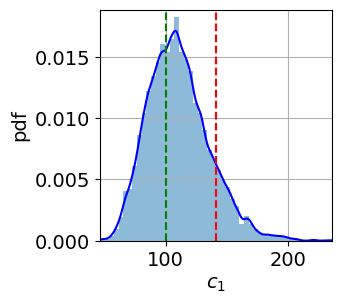

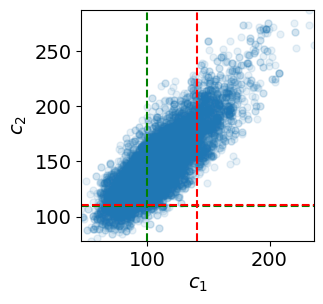

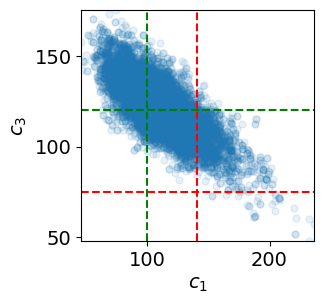

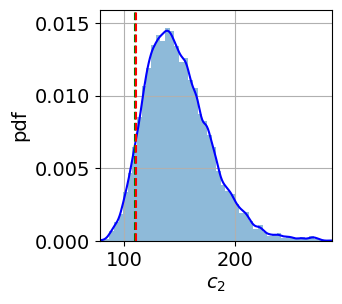

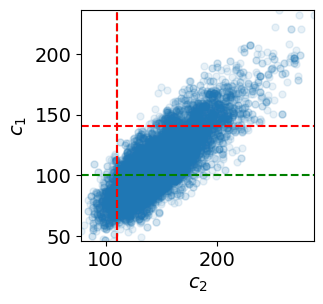

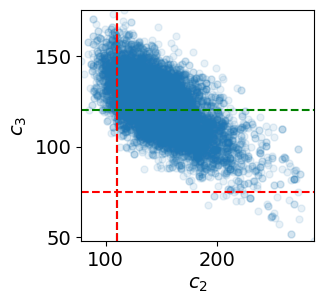

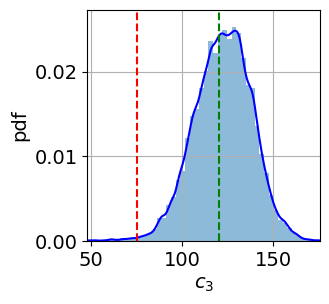

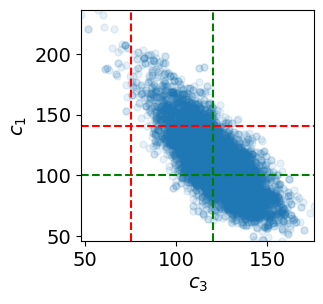

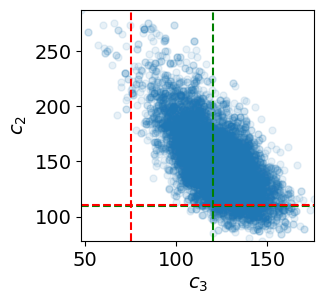

In [11]:
mpl.rcParams.update({'font.size':14})
statSmp = Xsmp
bandwidth = [0.1,0.1,0.1]


for j in range(0,Npar):
    xlow,xup = np.min(statSmp[j,:]),np.max(statSmp[j,:])
    f, ax = plt.subplots(1, figsize=(3,3))
    #Xpdf = st.kde.gaussian_kde(statSmp[j,:])
    Xpdf = st.kde.gaussian_kde(statSmp[j,:],bw_method = bandwidth[j])
    print(Xpdf.silverman_factor())
    Xgrd = np.linspace(xlow,xup,201)
    # Xgrd = np.linspace(X_low[j],X_up[j],100)
    plt.plot(Xgrd,Xpdf(Xgrd),'b-')
    plt.hist(statSmp[j,:], bins=50, density=True,alpha=0.5)
    pdfmax = max(Xpdf(Xgrd))
    myYlim = [0.0, 1.1*pdfmax]
    plt.plot([phiTrue[j],phiTrue[j]],myYlim,'--g',label='True')
    plt.plot([phiNN[j],phiNN[j]],myYlim,'--r',label='True')
    # plt.legend(loc='upper left', numpoints = 1)
    plt.ylabel('pdf')
    plt.xlabel(mylabel[j])
    #plt.xlim([np.min(statSmp[j,:]),np.max(statSmp[j,:])])
    plt.ylim(myYlim)
    plt.xlim([xlow,xup])
    # plt.xlim([X_low[j],X_up[j]])
    # plt.yticks([])
    plt.grid(True)
    # plt.savefig('mpdf_'+str(j)+'.pdf',bbox_inches='tight')

    for jj in range(Npar):
        if j != jj:            
            ylow,yup = np.min(statSmp[jj,:]),np.max(statSmp[jj,:])
            f, ax = plt.subplots(1, figsize=(3,3))
            plt.scatter(statSmp[j,::1],statSmp[jj,::1],alpha=0.1,s=25)
            plt.plot([xlow,xup],[phiTrue[jj],phiTrue[jj]],'--g',label='True')
            plt.plot([phiTrue[j],phiTrue[j]],[ylow,yup],'--g',label='True')
            plt.plot([xlow,xup],[phiNN[jj],phiNN[jj]],'--r',label='True')
            plt.plot([phiNN[j],phiNN[j]],[ylow,yup],'--r',label='True')
            plt.xlim([xlow,xup])
            plt.ylim([ylow,yup])
            # plt.xlim([X_low[j],X_up[j]])
            # plt.ylim([X_low[jj],X_up[jj]])
            plt.xlabel(mylabel[j])
            plt.ylabel(mylabel[jj])
            # plt.ylim([0,5e5])
            # plt.xlim([0,8e5])
            # plt.savefig('figures/m1_jpdf_'+ str(ii)+str(jj)+'.pdf',bbox_inches='tight')
            # plt.close()

/tmp/ipykernel_54109/4196835614.py:10: DeprecationWarning: Please use `gaussian_kde` from the `scipy.stats` namespace, the `scipy.stats.kde` namespace is deprecated.
  Xpdf = st.kde.gaussian_kde(statSmp[j,:],bw_method = 0.25)


0.1678756654970775
0.1678756654970775
0.1678756654970775


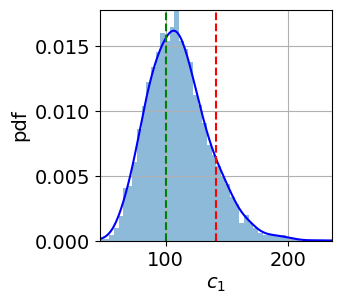

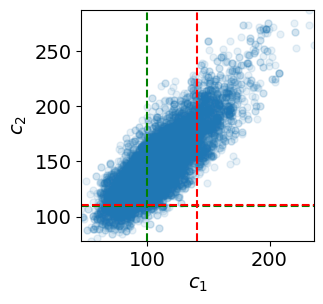

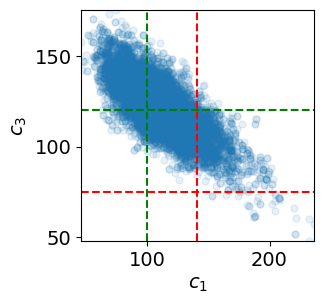

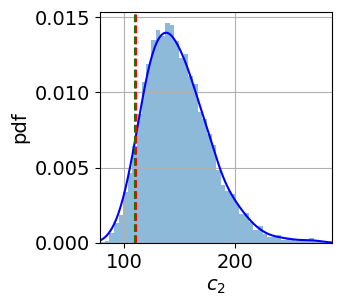

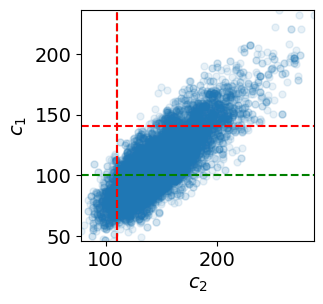

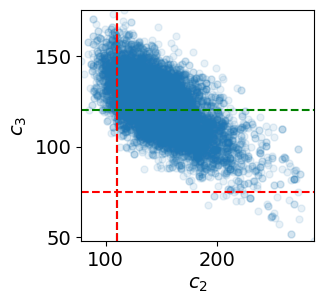

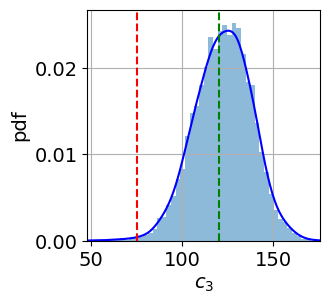

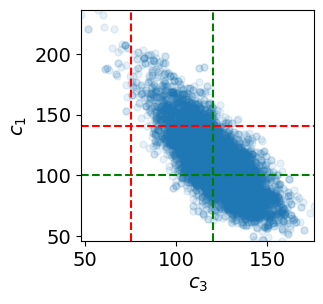

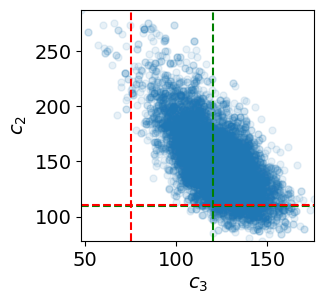

In [12]:
mpl.rcParams.update({'font.size':14})
statSmp = Xsmp
bandwidth = [0.1,0.1,0.1]


for j in range(0,Npar):
    xlow,xup = np.min(statSmp[j,:]),np.max(statSmp[j,:])
    f, ax = plt.subplots(1, figsize=(3,3))
    #Xpdf = st.kde.gaussian_kde(statSmp[j,:])
    Xpdf = st.kde.gaussian_kde(statSmp[j,:],bw_method = 0.25)
    print(Xpdf.silverman_factor())
    Xgrd = np.linspace(xlow,xup,201)
    # Xgrd = np.linspace(X_low[j],X_up[j],100)
    plt.plot(Xgrd,Xpdf(Xgrd),'b-')
    plt.hist(statSmp[j,:], bins=50, density=True,alpha=0.5)
    pdfmax = max(Xpdf(Xgrd))
    myYlim = [0.0, 1.1*pdfmax]
    plt.plot([phiTrue[j],phiTrue[j]],myYlim,'--g',label='True')
    plt.plot([phiNN[j],phiNN[j]],myYlim,'--r',label='PINN')
    # plt.legend(loc='upper left', numpoints = 1)
    plt.ylabel('pdf')
    plt.xlabel(mylabel[j])
    #plt.xlim([np.min(statSmp[j,:]),np.max(statSmp[j,:])])
    plt.ylim(myYlim)
    plt.xlim([xlow,xup])
    # plt.xlim([X_low[j],X_up[j]])
    # plt.yticks([])
    plt.grid(True)
    # plt.legend()
    #plt.savefig('mpdf_'+str(j)+'.pdf',bbox_inches='tight')

    for jj in range(Npar):
        if j != jj:            
            ylow,yup = np.min(statSmp[jj,:]),np.max(statSmp[jj,:])
            f, ax = plt.subplots(1, figsize=(3,3))
            plt.scatter(statSmp[j,::1],statSmp[jj,::1],alpha=0.1,s=25)
            plt.plot([xlow,xup],[phiTrue[jj],phiTrue[jj]],'--g')
            plt.plot([phiTrue[j],phiTrue[j]],[ylow,yup],'--g')
            plt.plot([xlow,xup],[phiNN[jj],phiNN[jj]],'--r')
            plt.plot([phiNN[j],phiNN[j]],[ylow,yup],'--r')
            plt.xlim([xlow,xup])
            plt.ylim([ylow,yup])
            # plt.xlim([X_low[j],X_up[j]])
            # plt.ylim([X_low[jj],X_up[jj]])
            plt.xlabel(mylabel[j])
            plt.ylabel(mylabel[jj])
            # plt.ylim([0,5e5])
            # plt.xlim([0,8e5])
            #plt.savefig('jpdf_'+ str(j)+str(jj)+'.pdf',bbox_inches='tight')
            # plt.close()

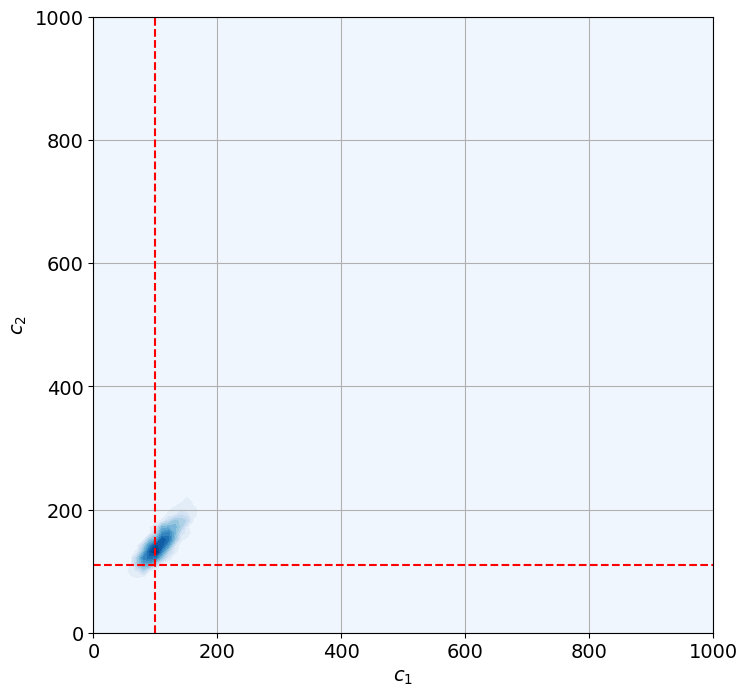

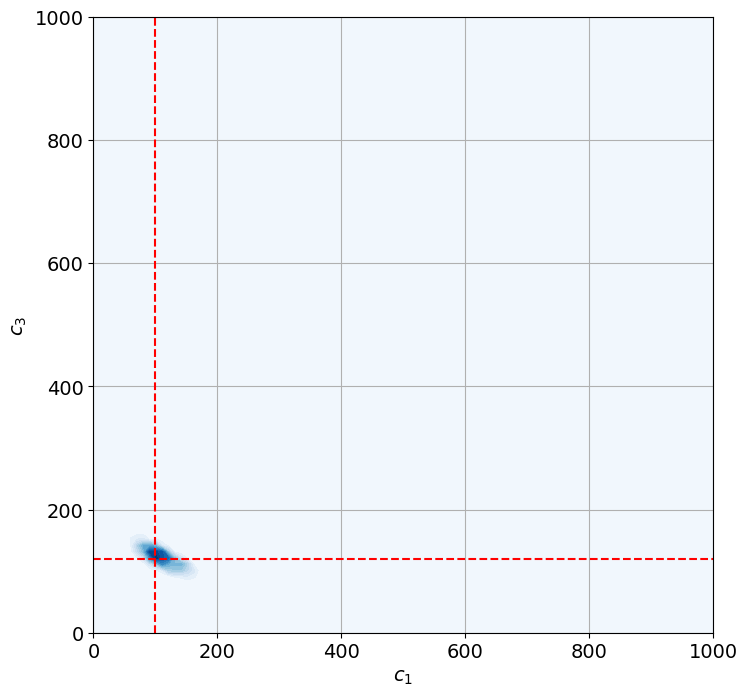

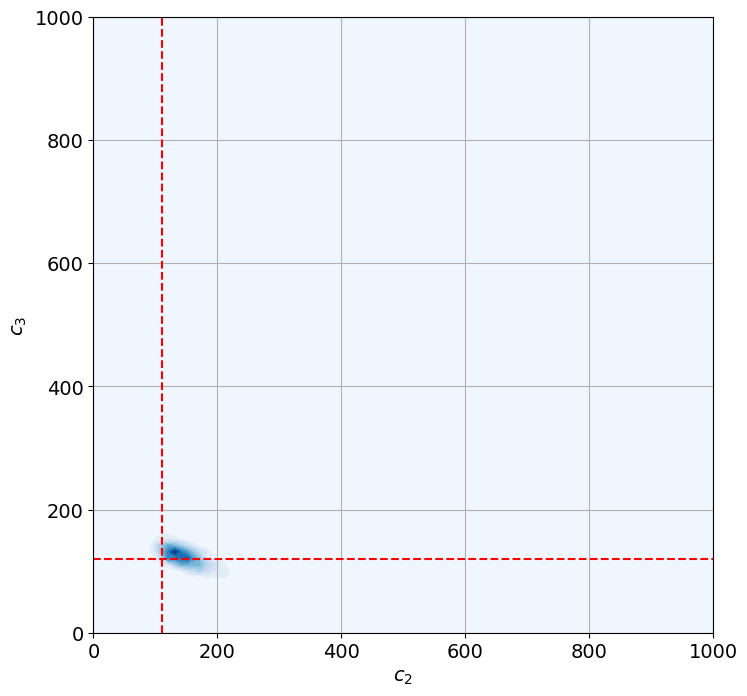

In [13]:
msize = 1.2
for i in range(0,Npar):
    for j in range(i+1,Npar):
        fig = plt.figure(Npar*i+j,figsize=(8,8))
        xmin = X_low[i]
        xmax = X_up[i]
        ymin = X_low[j]
        ymax = X_up[j]
        x = Xsmp[i,:]
        y = Xsmp[j,:]
        xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
        positions = np.vstack([xx.ravel(), yy.ravel()])
        values = np.vstack([x, y])
        kernel = st.gaussian_kde(values,bw_method = 0.1)
        f = np.reshape(kernel(positions).T, xx.shape)
        ax = fig.gca()
        # Contourf plot
        cfset = ax.contourf(xx, yy, f, 15,cmap='Blues')
        ## Or kernel density estimate plot instead of the contourf plot
        #ax.imshow(np.rot90(f), cmap='Blues', extent=[xmin, xmax, ymin, ymax])
        # Contour plot
        #cset = ax.contour(xx, yy, f, colors='k')
        # Label plot
        #ax.clabel(cset, inline=1, fontsize=10)
        plt.plot([X_low[i],X_up[i]],[phiTrue[j],phiTrue[j]],'r--')
        plt.plot([phiTrue[i],phiTrue[i]],[X_low[j],X_up[j]],'r--')
        plt.xlabel(mylabel[i])
        plt.ylabel(mylabel[j])
        plt.xlim([xmin,xmax])
        plt.ylim([ymin,ymax])
        plt.grid(True)
        # plt.savefig('jpdf_post'+str(i+1)+str(j+1)+'.eps',bbox_inches='tight')

In [14]:
mpl.rcParams.update({'font.size':12})
Ytrue = two_dof_forecast(phiTrue)
Nreal = 500
Yreal = np.zeros((2*dof,Nreal,tgrd_true))
Ystd = np.zeros((2*dof,tgrd_true))
Ymean = np.zeros((2*dof,tgrd_true))

# c_map = [4,400]

muVec = Xsmp
# Ymap = Yresponse(c_map)
for j in range(0,Nreal):
  Ysim = two_dof_forecast(muVec[:,j*1])
  for i in range(2*dof):
    #Ysim = Yresponse([0,0,muVec[j]])
    Yreal[i,j,:] = Ysim[i,:]

for i in range(2*dof):
  Ystd[i,:] = np.std(Yreal[i,:,:],0)
  Ymean[i,:] = np.mean(Yreal[i,:,:],0)


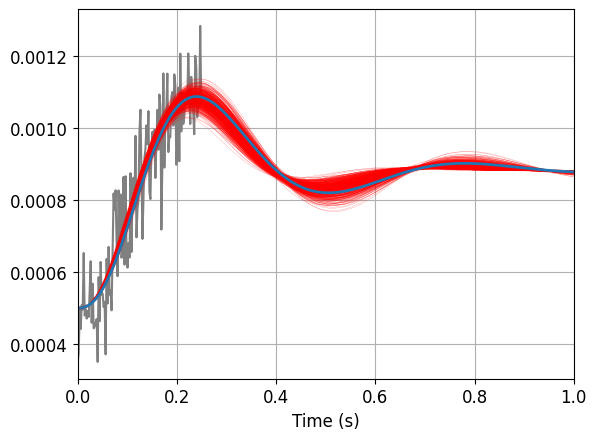

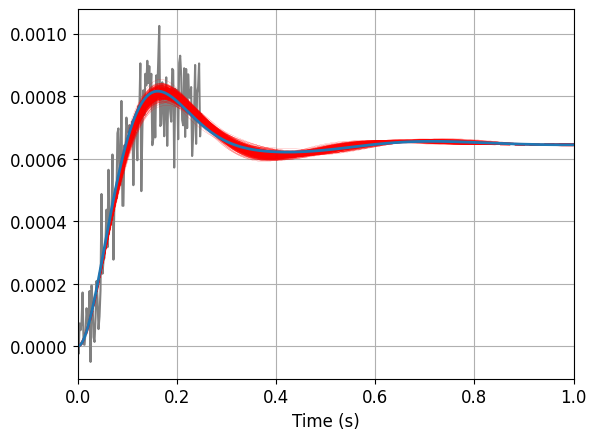

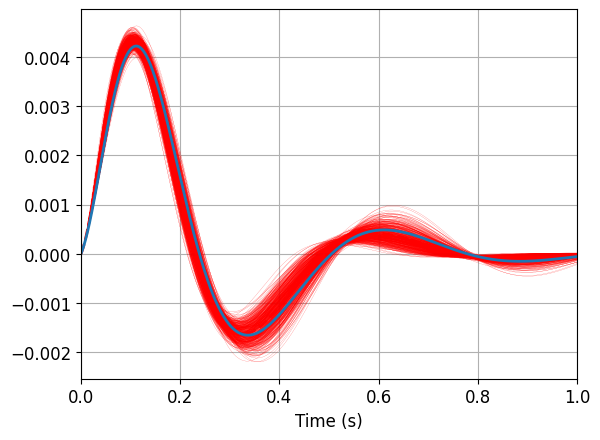

<Figure size 800x300 with 0 Axes>

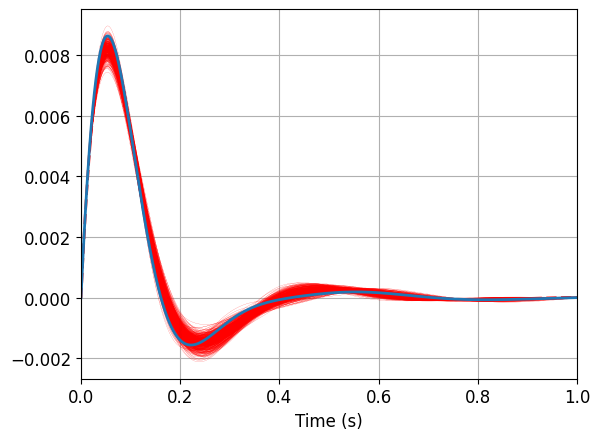

In [15]:
for i in range(2*dof):
  lwidth = 0.1
  plt.figure(1,figsize=(8,3))
  fig, ax = plt.subplots()
  #plt.plot(tobs,Yobs,'k.',label='Observations')
  plt.grid(True)
  plt.xlabel('Time (s)')
  plt.xlim([-0.001,T])
  if i in [0,1]:
    # plt.scatter(tobs,Yobs[i,:],color='w',edgecolor='k')
    plt.plot(tobs,Yobs[i,:],color='grey')
  plt.plot(tlist_true,Ymean[i,:],color='r',linestyle='--',linewidth=2,label='Predicted')
  plt.plot(tlist_true,Yreal[i,:].T,linewidth=0.1,alpha=1,color='r')
  # plt.plot(tlist,Ymean[i,:]+2*Ystd[i,:],color='tab:red',linestyle='--',linewidth=1.2,label='99/% region')
  # plt.plot(tlist,Ymean[i,:]-2*Ystd[i,:],color='tab:red',linestyle='--',linewidth=1.2)

  #   plt.legend(loc='upper right', numpoints = 1)
  # ax.fill_between(tlist, Y2, Y1, where=Y2 >= Y1, facecolor='pink', interpolate=True)
  plt.plot(tlist_true,Ytrue[i,:],'tab:blue',linewidth=2,label = 'True')
  plt.xlim([0,1])
  # plt.ylim([-50,50])
  # plt.savefig('figs/predictions_before_dof_'+str(i)+'.pdf',bbox_inches='tight')

Text(0, 0.5, 'Displacement (mm)')

<Figure size 800x300 with 0 Axes>

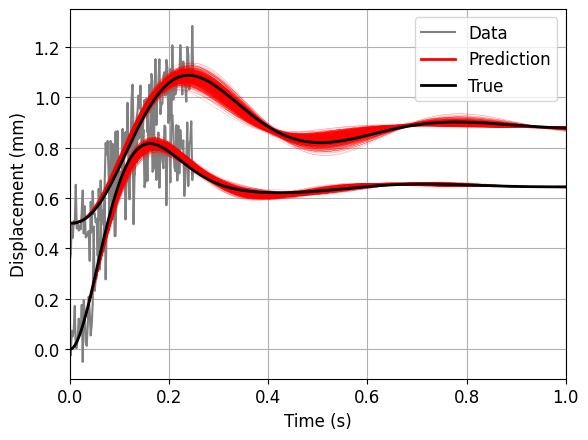

In [16]:
lwidth = 0.1
plt.figure(1,figsize=(8,3))
fig, ax = plt.subplots()
#plt.plot(tobs,Yobs,'k.',label='Observations')
plt.grid(True)
plt.xlabel('Time (s)')
plt.xlim([-0.001,T])
  # plt.scatter(tobs,Yobs[i,:],color='w',edgecolor='k')
plt.plot(tobs,1000*Yobs[0,:],color='grey',label='Data')
plt.plot(tobs,1000*Yobs[1,:],color='grey')
plt.plot(tlist_true,1000*Ymean[0,:],color='r',linestyle='-',linewidth=2,label='Prediction')
plt.plot(tlist_true,1000*Yreal[0,:].T,linewidth=0.1,alpha=1,color='r')
plt.plot(tlist_true,1000*Yreal[1,:].T,linewidth=0.1,alpha=1,color='r')
# plt.plot(tlist,Ymean[i,:]+2*Ystd[i,:],color='tab:red',linestyle='--',linewidth=1.2,label='99/% region')
# plt.plot(tlist,Ymean[i,:]-2*Ystd[i,:],color='tab:red',linestyle='--',linewidth=1.2)

#   plt.legend(loc='upper right', numpoints = 1)
# ax.fill_between(tlist, Y2, Y1, where=Y2 >= Y1, facecolor='pink', interpolate=True)
plt.plot(tlist_true,1000*Ytrue[0,:],'k',linewidth=2,label = 'True')
plt.plot(tlist_true,1000*Ytrue[1,:],'k',linewidth=2)
plt.xlim([0,1])
plt.legend()
plt.ylabel('Displacement (mm)')
# plt.ylim([-50,50])
#plt.savefig('predictions_'+str(i)+'.pdf',bbox_inches='tight')